In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import joblib

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = 'C:/Users/Daniel/Desktop/NSCLC-Radiomics/patients/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
labels_df = pd.read_csv('Lung1.clinical.csv',index_col = 0)

In [2]:
labels_df.head()

,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Overall.Stage,Histology,gender,Survival.time,deadstatus.event
PatientID,,,,,,,,,
LUNG1-001,78.7515,2.0,3,0,IIIb,large cell,male,2165,1
LUNG1-002,83.8001,2.0,0,0,I,squamous cell carcinoma,male,155,1
LUNG1-003,68.1807,2.0,3,0,IIIb,large cell,male,256,1
LUNG1-004,70.8802,2.0,1,0,II,squamous cell carcinoma,male,141,1
LUNG1-005,80.4819,4.0,2,0,IIIb,squamous cell carcinoma,male,353,1


hu = pixel_value * slope + intercept

Normally, these values are stored in the DICOM file itself. The tags are generally called the Rescale Slope and Rescale Intercept, and typically have values of 1 and -1024, respectively.

In [4]:
for patient in patients[:1]:
    label = labels_df.get_value(patient,'Overall.Stage')
    path = INPUT_FOLDER + patient
#     slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
#     slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
# #     print(len(slices), slices[0].pixel_array.shape)
#     plt.imshow(slices[0].pixel_array)
#     plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [5]:
label

'IIIb'

In [6]:
# Load the scans in given folder path
def load_scan(path):
    _, __, files = os.walk(path)
    slices = [dicom.read_file(files[0] + '/' + s) for s in os.listdir(files[0])]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [7]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

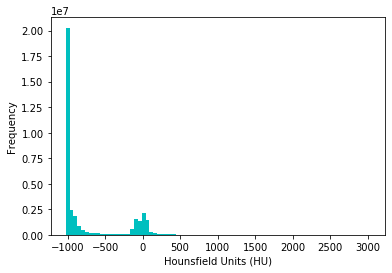

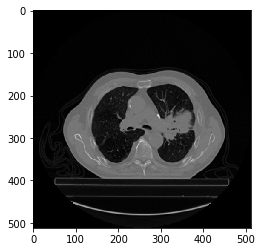

In [8]:
first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [9]:
first_patient_pixels

array([[[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ...,
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024]],

       [[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ...,
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024]],

       [[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ...,
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -10

In [10]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [11]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (134, 512, 512)
Shape after resampling	 (402, 500, 500)


In [14]:
# much_data = []
for num,patient in enumerate(patients):
    print(num)
    try:
        label = labels_df.get_value(patient,'Overall.Stage')
        patient_info = load_scan(INPUT_FOLDER + patients[num])
        patient_dicom_pixels = get_pixels_hu(patient_info)
        pix_resampled, spacing = resample(patient_dicom_pixels, patient_info, [1,1,1])
        np.save(f'./{label}/{patient}.npy', pix_resampled)
#         much_data.append(pix_resampled)
    except:
        print(f'{patient} failed to be stored')

# np.save('patient_data.npy', much_data)

0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
LUNG1-272 failed to be s

In [27]:
much_data[100]

array([[[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ...,
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024]],

       [[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ...,
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024]],

       [[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ...,
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -10

In [16]:
len(much_data)

307

In [26]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [27]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

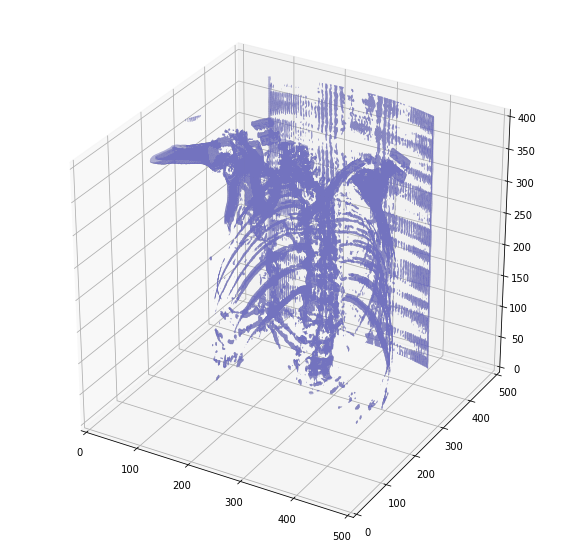

In [98]:
plot_3d(pix_resampled, 400)

In [28]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

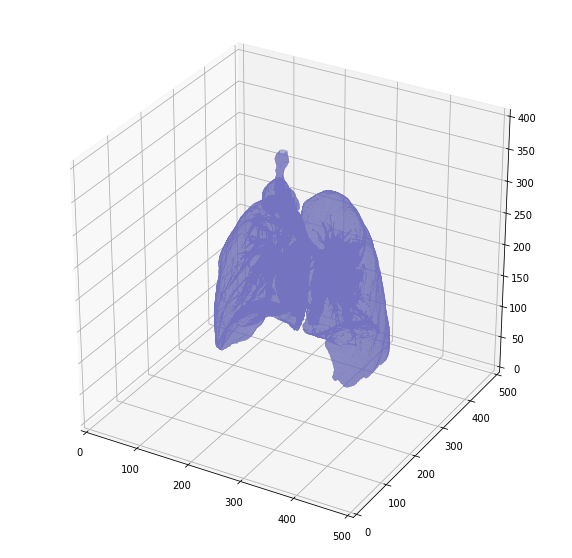

In [29]:
plot_3d(segmented_lungs, 0)

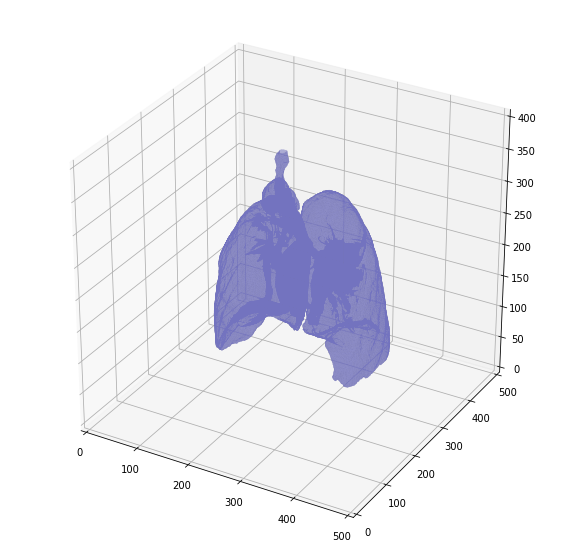

In [30]:
plot_3d(segmented_lungs_fill, 0)

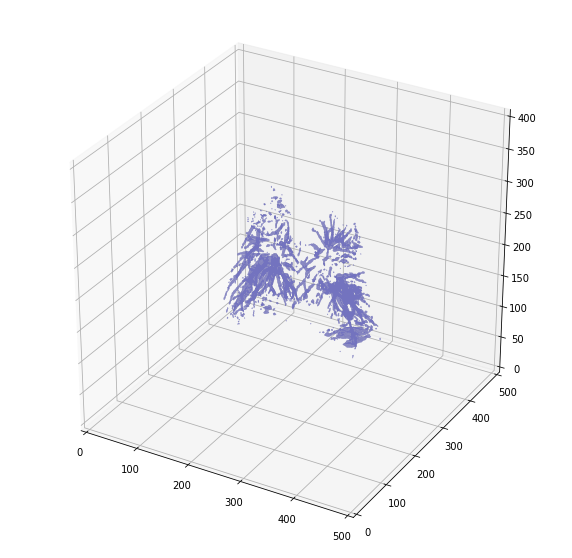

In [31]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

In [32]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

In [33]:
# PIXEL_MEAN = 0.25

# def zero_center(image):
#     image = image - PIXEL_MEAN
#     return image

In [94]:
segmented_lungs_fill.shape

(402, 500, 500)